# Correntes médias para cada estação do modelo maré+ventos

In [1]:
import pooch
import xarray as xr

url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_winds.nc",
    known_hash="sha256:1b01945c529e9f0489a659fc8360344ff58925544a2f7e543148d4f31c6dd0e8",
)

ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (time: 8772, m: 138, n: 218)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-01-01
Data variables:
    waterlevel  (time, m, n) float32 ...
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Mon Aug 22 14:21:18 2022: ncks -4 -L 1 jan...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.0 (Homepage =...

Médias sazonais

import numpy as np


coast_mask = np.ma.masked_invalid(u.to_numpy()).mask
np.savez_compressed("coast_mask.npz", coast_mask=coast_mask)

In [2]:
from pathlib import Path

import numpy as np

fname = Path("season_avg.nc")

if not fname.exists():
    month_length = ds["time"].dt.days_in_month

    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")

    # Salva o arquivo para não precisar recalcular.
    ds_weighted.to_netcdf(fname)
else:
    ds_weighted = xr.open_dataset(fname)

ds_weighted

<xarray.Dataset>
Dimensions:     (m: 138, n: 218, season: 4)
Coordinates:
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    waterlevel  (season, m, n) float64 ...
    velocity_x  (season, m, n) float64 ...
    velocity_y  (season, m, n) float64 ...

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def plot_currents(ax, ds_weighted, season="DJF"):
    subset = ds_weighted.sel({"season": season})

    u = subset["velocity_x"]
    v = subset["velocity_y"]

    u_norm = u / np.sqrt(u**2.0 + v**2.0)
    v_norm = v / np.sqrt(u**2.0 + v**2.0)

    speed = (u**2 + v**2) ** 0.5
    masked_speed = np.ma.masked_array(speed, speed.to_numpy() == 0)

    ax.contourf(subset["longitude"], subset["latitude"], masked_speed)
    ax.quiver(
        subset["longitude"], subset["latitude"], u_norm, v_norm, color="white", scale=50
    )

    ax.coastlines(resolution="10m");

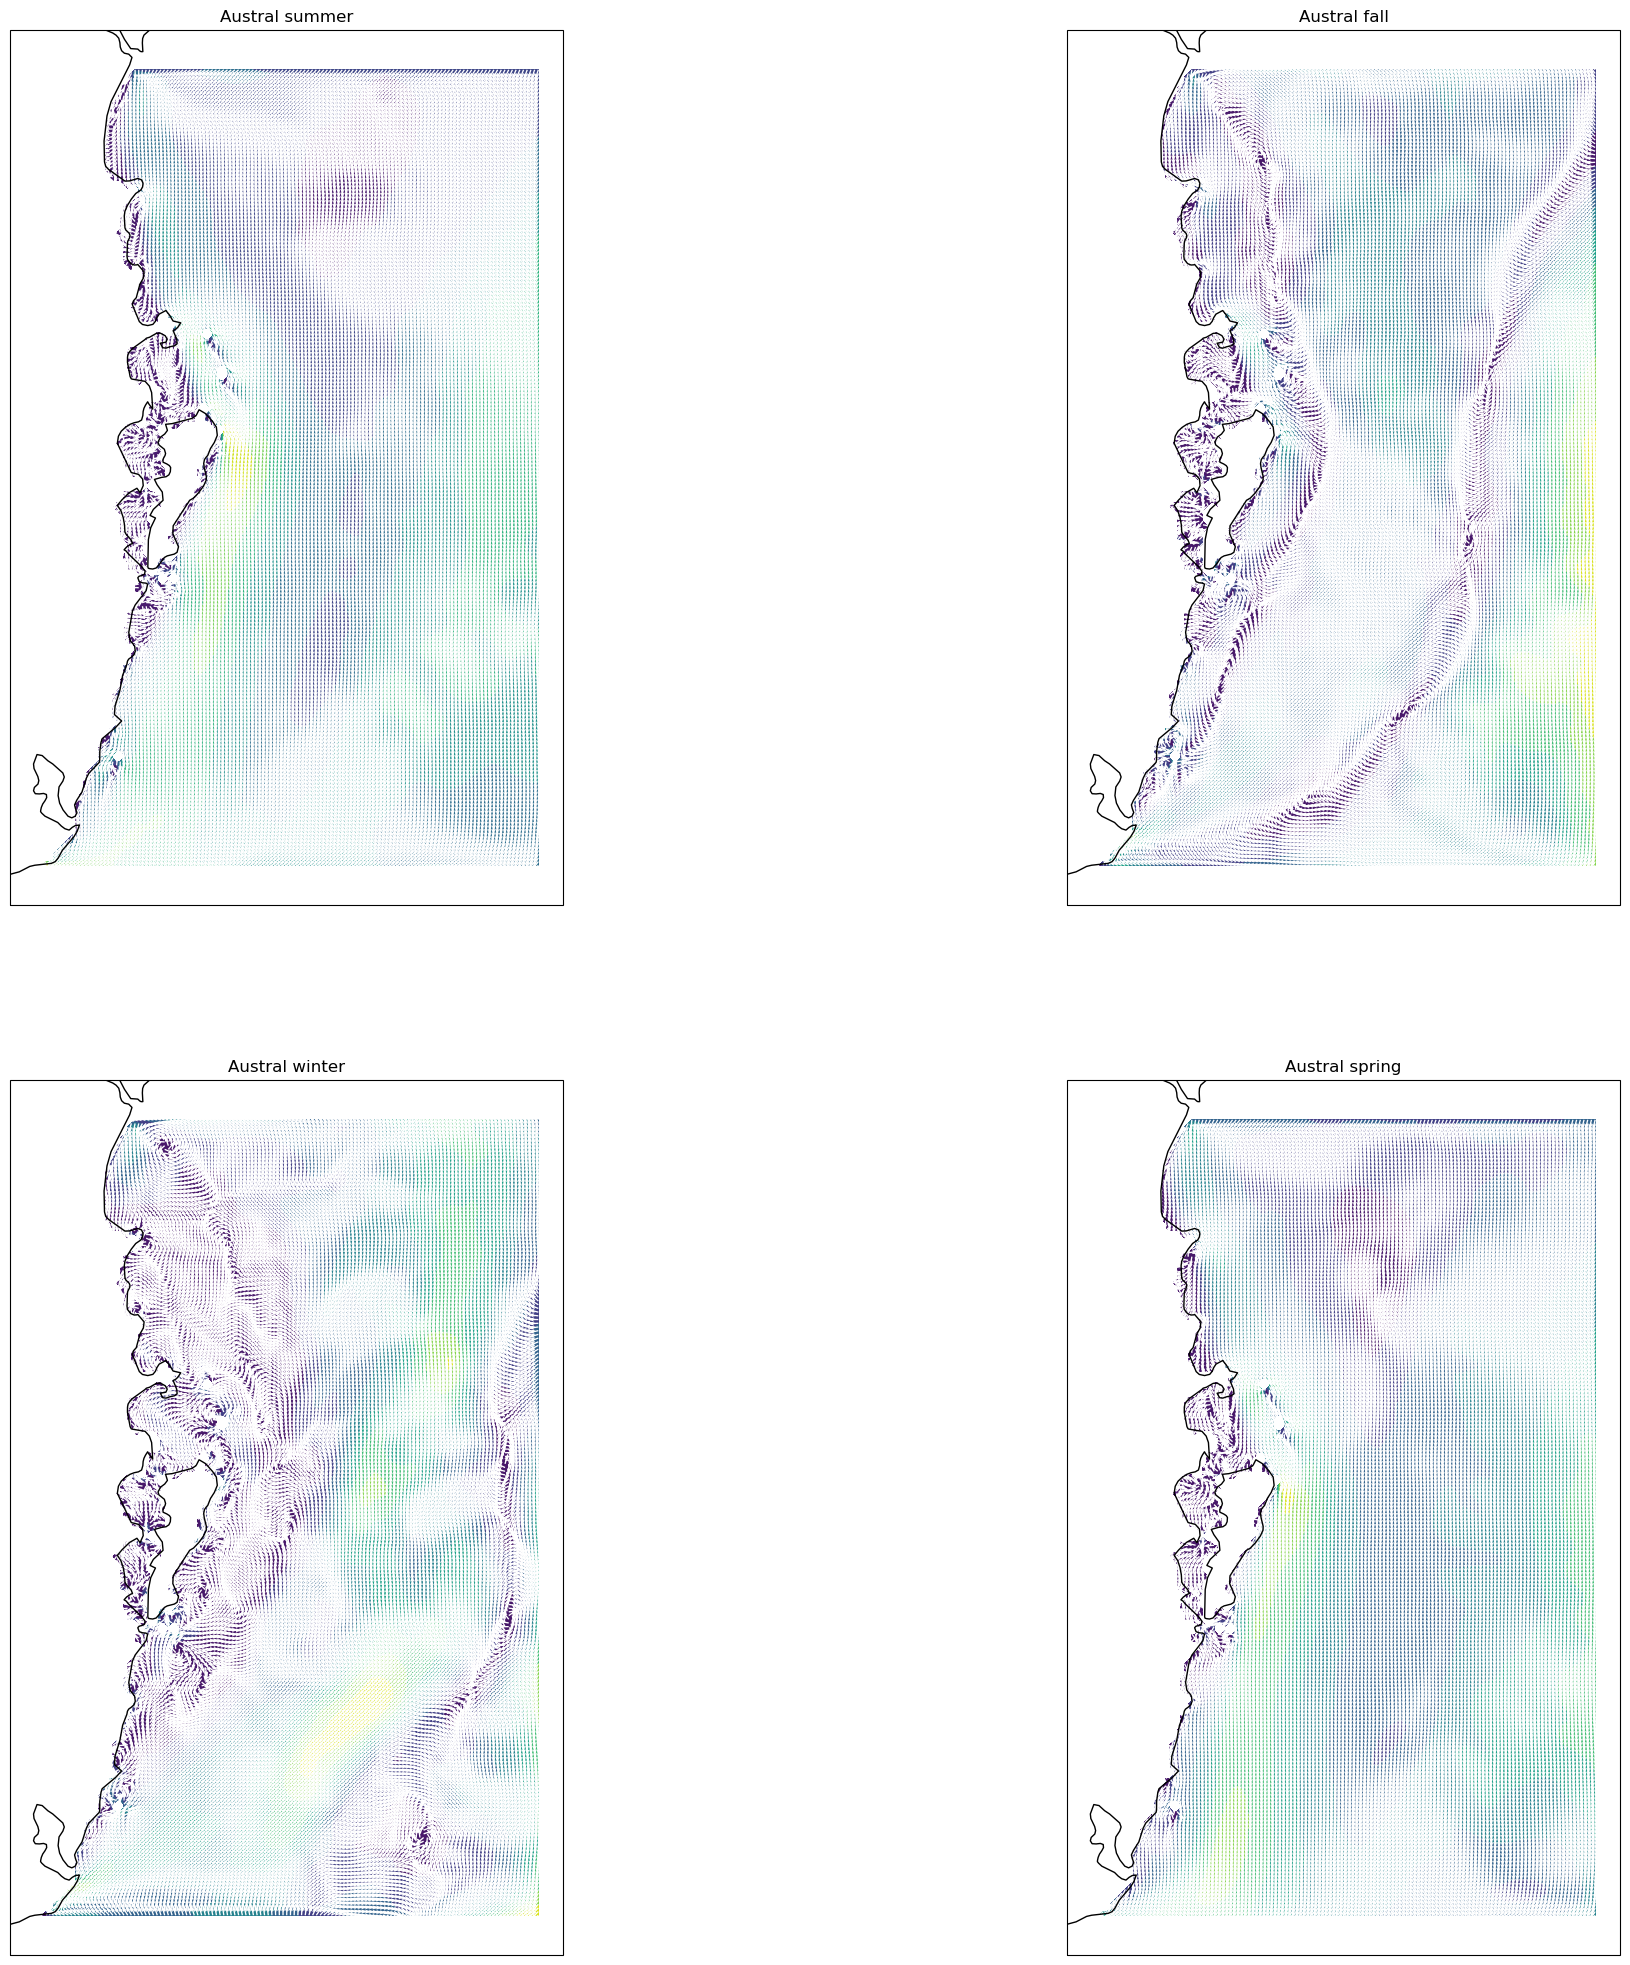

In [4]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    nrows=2, ncols=2, figsize=(25, 25), subplot_kw={"projection": ccrs.PlateCarree()}
)

ax0.set_title("Austral summer")
plot_currents(ax0, ds_weighted, season="DJF")

ax1.set_title("Austral fall")
plot_currents(ax1, ds_weighted, season="MAM")

ax2.set_title("Austral winter")
plot_currents(ax2, ds_weighted, season="JJA")

ax3.set_title("Austral spring")
plot_currents(ax3, ds_weighted, season="SON")